In [55]:
%load_ext sql
import statsmodels.api as sma
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import datetime
from scipy import stats
import math

from mpl_toolkits.basemap import Basemap # Basemap must be imported before Shapely due to conflict
import fiona
import shapely as shapely
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import asShape
from time import gmtime, strftime
from array import array


# imports
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math

# follow the usual sklearn pattern: import, instantiate, fit
from sklearn.linear_model import LinearRegression
import numpy as np

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import statsmodels.formula.api as sm

# this allows plots to appear directly in the notebook
%matplotlib inline

# city abbreviation code
city = 'ph'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [56]:
%sql mysql://root:@localhost/rental_nerd

u'Connected: root@rental_nerd'

In [57]:
query = %sql (\
SELECT  \
properties.id as 'property_id', \
properties.address,  \
properties.bedrooms,  \
properties.bathrooms,  \
properties.sqft,  \
properties.source,  \
properties.origin_url,  \
properties.longitude,  \
properties.latitude,  \
properties.elevation,  \
(2016 - properties.year_built) as 'age',  \
properties.garage,  \
properties.level,  \
properties.luxurious,  \
properties.dist_to_park,  \
properties.zipcode, \
properties.dist_to_golf_course, \
properties.near_golf_course, \
properties.has_pool, \
properties.home_type, \
property_transaction_logs.id 'ptl_id',  \
property_transaction_logs.transaction_type,  \
property_transaction_logs.price,  \
property_transaction_logs.transaction_status,  \
property_transaction_logs.days_on_market,  \
property_transaction_logs.date_closed as 'date',  \
property_transaction_logs.date_listed,  \
neighborhoods.name as 'neighborhood',  \
neighborhoods.id as 'nid',  \
neighborhoods.shapefile_source,  \
property_school_districts.school_district_id \
FROM  \
properties,  \
property_transaction_logs,  \
property_neighborhoods,  \
neighborhoods,  \
property_school_districts \
WHERE  \
property_school_districts.property_id = properties.id AND  \
property_transaction_logs.property_id = properties.id AND  \
property_transaction_logs.transaction_type = "rental" AND  \
property_transaction_logs.date_closed is not null AND \
neighborhoods.shapefile_source = "PH" AND  \
properties.id = property_neighborhoods.property_id AND  \
property_neighborhoods.neighborhood_id = neighborhoods.id AND \
properties.sqft > 0 AND \
properties.bedrooms IS NOT NULL AND \
properties.bathrooms IS NOT NULL AND \
properties.elevation IS NOT NULL AND \
properties.level IS NOT NULL AND \
properties.dist_to_park IS NOT NULL AND \
properties.near_golf_course IS NOT NULL AND \
properties.home_type IS NOT NULL AND \
properties.zipcode IS NOT NULL AND \
properties.sqft IS NOT NULL AND \
properties.year_built IS NOT NULL AND \
property_transaction_logs.price > 0 )
           
    
# properties.has_pool IS NOT NULL AND \
# properties.garage IS NOT NULL AND \
data = query.DataFrame()

53977 rows affected.


In [58]:
# query = %sql (\
# SELECT  \
# properties.address, \
# properties.bedrooms, \
# properties.bathrooms, \
# properties.sqft, \
# properties.source, \
# properties.origin_url, \
# properties.longitude, \
# properties.latitude, \
# properties.elevation, \
# properties.year_built, \
# properties.garage, \
# properties.level, \
# property_transactions.transaction_type, \
# property_transaction_logs.price, \
# property_transaction_logs.transaction_status, \
# property_transaction_logs.days_on_market, \
# property_transaction_logs.date_closed, \
# property_transaction_logs.date_listed, \
# neighborhoods.name as 'neighborhood', \
# neighborhoods.id as 'nid', \
# neighborhoods.shapefile_source \
# FROM \
# properties, \
# property_transactions, \
# property_transaction_logs, \
# property_neighborhoods, \
# neighborhoods \
# WHERE \
# properties.id = property_transactions.property_id AND \
# property_transactions.property_transaction_log_id = property_transaction_logs.id AND \
# property_transactions.transaction_type = "rental" AND \
# neighborhoods.shapefile_source = "SF" AND \
# properties.id = property_neighborhoods.property_id AND \
# property_neighborhoods.neighborhood_id = neighborhoods.id)

# data = query.DataFrame()
# data_copy = data

In [59]:
# create a column of GeoSeries - each house should be represented by a point
pts = GeoSeries([Point(x, y) for x, y in zip(data['longitude'], data['latitude'])])
data['latlong'] = pts

In [60]:
# create year dummy variables (because date isn't very intuitive variable)
data["year"] = pd.DatetimeIndex(data["date"]).to_period('A')
data["month"] = pd.DatetimeIndex(data["date"]).to_period('M')

In [61]:
data["near_golf_course"] = data["near_golf_course"].apply(lambda x: True if x == 1.0 else False)
data["has_pool"] = data["has_pool"].apply(lambda x: True if x == 1.0 else False)
data["garage"] = data["garage"].apply(lambda x: True if x == 1.0 else False)

In [62]:
data.describe() #identify filtering tresholds to clean up bad data

,property_id,bedrooms,bathrooms,sqft,longitude,latitude,elevation,age,garage,level,dist_to_park,dist_to_golf_course,near_golf_course,has_pool,ptl_id,price,days_on_market,nid,school_district_id
count,53977.000000,53977.000000,53977.000000,53977.000000,53977.000000,53977.000000,53977.000000,53977.000000,53977,53977.000000,53977.000000,53977.000000,53977,53977,53977.000000,53977.000000,12081.000000,53977.000000,53977.000000
mean,720295.598236,3.114160,2.095744,1828.150416,-112.058933,33.505135,389.824982,25.527984,0.0944106,1.064064,0.008871,0.019478,0.0556163,0.0769587,2147256.281324,2355.360098,269.353613,306.134483,115.545436
std,674186.808410,1.013128,1.261902,968.863286,0.226849,0.143941,81.694002,17.394295,0.292402,1.072986,0.016683,0.020530,0.229181,0.266528,996371.198316,9531.963426,447.145157,138.141568,58.715463
min,652.000000,0.000000,0.000000,1.000000,-113.176000,32.257000,220.537000,0.000000,False,1.000000,0.000000,0.000000,False,False,5382.000000,1.000000,0.000000,94.000000,4.000000
25%,192421.000000,3.000000,2.000000,1329.000000,-112.225000,33.403000,339.339000,12.000000,0,1.000000,0.002691,0.006896,0,0,1363998.000000,1000.000000,14.000000,176.000000,60.000000
50%,432911.000000,3.000000,2.000000,1651.000000,-112.092000,33.491700,375.527000,19.000000,0,1.000000,0.006013,0.016323,0,0,2150255.000000,1250.000000,46.000000,288.000000,124.000000
75%,1159203.000000,4.000000,2.000000,2111.000000,-111.875000,33.612200,413.025000,36.000000,0,1.000000,0.011004,0.028064,0,0,3005964.000000,1695.000000,356.000000,462.000000,168.000000
max,2633995.000000,12.000000,175.000000,111123.000000,-110.894000,33.979900,1028.370000,398.000000,True,40.000000,1.205310,1.210900,True,True,4895574.000000,999999.000000,3162.000000,502.000000,225.000000


In [63]:
# filter out any outliers, defined as rent >$10k or >2,500 sq ft, or not in SF

print "Entries before filter: " + `len(data)`
data = data[  (data.sqft <= 10000) 
            & (data.price <= 4000) 
            & (data.price > 500)
#            & (data.neighborhood == 'South Scottsdale')
#             & (data.home_type == 'sfh')
#             & (data.transaction_status == 'closed')
            & (data.bedrooms <= 6) 
            & (data.bathrooms <= 6) 
            & (data.sqft != 0)
            & (data.year > pd.Period('2000', freq='A-DEC'))]

print "Entries after filter: " + `len(data)`


Entries before filter: 53977
Entries after filter: 50661


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11dfcc990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1227e35d0>]], dtype=object)

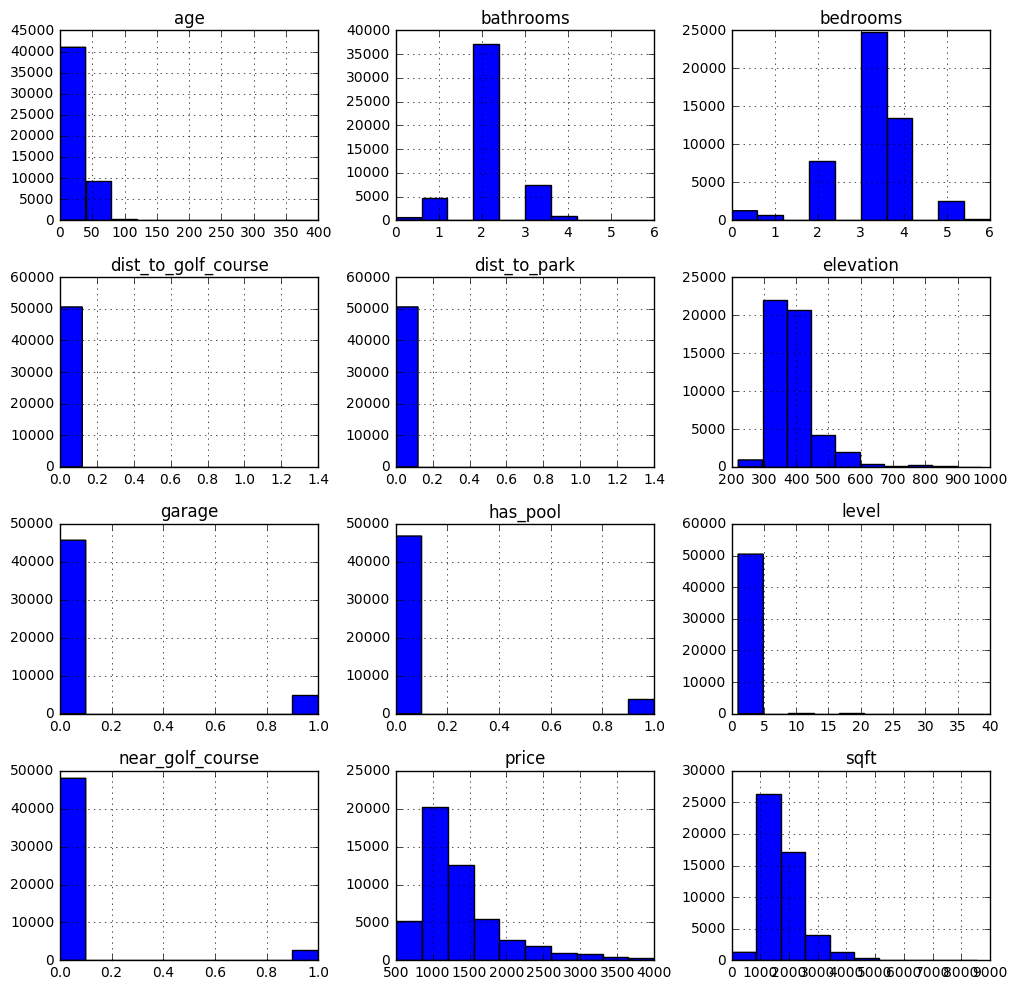

In [64]:
data.hist(column=['has_pool','bathrooms','bedrooms','price','garage','level','age','sqft','elevation','luxurious','dist_to_park', 'dist_to_golf_course','near_golf_course'],figsize=(12,12))

In [65]:
# adjust variables so that for most houses they result in zero (or close to zero)
data.elevation = data.elevation - 295
data.level = data.level - 1
data.bathrooms = data.bathrooms - 1

In [66]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    


In [67]:
# Artnet white paper index converted to our dataset

# create year dummy variables (because date isn't very intuitive variable)
z = 'A'
data["period"] = pd.DatetimeIndex(data["date"]).to_period(z)
data['period_literal'] = pd.DatetimeIndex(data["date"]).to_period(z).format()

paired = data[['address','date','price','period','period_literal','zipcode', 'neighborhood']]

# identify the earliest date, number of periods, and number of pairs
base_period = paired.period.min()
num_periods = paired.period.max() - paired.period.min()
print "base period: " + `base_period` + " end period: " + `paired.period.max()` + " and number of periods: " + `num_periods`

# group data into Sets and calc Y_ist of each item
paired = paired.groupby("address").filter(lambda x: len(x) >1)
paired.sort_values(['address','period'],inplace=True)
paired_grp = paired.groupby('address')

# filter out any houses with multiple transaction in a given period
paired = paired.groupby(['address','period_literal']).filter(lambda x: len(x) == 1)

# filter out any houses with only a single transaction ever
paired = paired.groupby(['address']).filter(lambda x: len(x) > 1)

print 'number of paired transactions in the data: ' + `paired.shape[0]`

base period: Period('2007', 'A-DEC') end period: Period('2016', 'A-DEC') and number of periods: 9
number of paired transactions in the data: 7565


In [68]:
def demean(group):
    return pd.DataFrame({'address': group.address, 'original' : group.price, 'demeaned' : group.price - group.price.mean()})

# filter out properties with multiple listings in the same year and listings that moved by 30% or more
paired_grp = paired.groupby('address')
n = paired.groupby(['address']).apply(demean)
n = n[((n.demeaned / n.original).abs() > 0.15)]

paired = paired[~paired.address.isin(n.address)]
print 'number of paired transactions after cleaning the data: ' + `paired.shape[0]`

number of paired transactions after cleaning the data: 7250


In [69]:
boundary = 'neighborhood' # 'zipcode' or 'neighborhood'

table = ListTable()
table.append([boundary,'Period','Growth Rate','P Value','n'])

sorted_zips = []

In [70]:
# index used to calculate adjusted prices. 
iterables = [data[boundary].unique(), data.period.unique()]
mi = pd.MultiIndex.from_product(iterables, names=[boundary, 'period'])
price_adjustment_index = pd.Series()



           Index  Growth Rate    P value     n
2008  100.000000     0.000000  89.884738     0
2009   99.701217    -0.002988  98.899581   113
2010   99.966851     0.002664  60.196150   225
2011   98.767008    -0.012002  73.464725   403
2012  100.802992     0.020614  77.655065   669
2013  100.670670    -0.001313  70.846283   899
2014  100.883195     0.002111  19.553593  1036
2015  103.089779     0.021873   1.734652  1711
2016  105.743862     0.025745   0.742993  2119


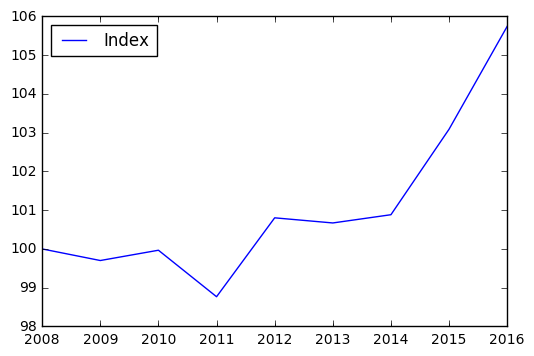

In [71]:
res = sm.ols(formula="np.log(price) ~ period + address", data=paired).fit()

#calculate index
linked = res.params[res.params.index.str.contains('Period')]
linked.name = "Index"
linked[0] = 100
num = pd.Series(linked, copy=True)
num[0] = 0
num.name = "n"
growth = pd.Series(linked, copy=True)
growth.name = "Growth Rate"
growth[0] = 0
for i in range(1,len(linked)):
    linked[i] = (np.exp(res.params[i]))*100
    growth[i] = linked[i]/linked[i-1] - 1
    num[i] = len(paired[paired.period_literal == filter(str.isdigit, linked.index[i])])

# add P values of each prediction
p = res.pvalues[res.params.index.str.contains('Period')] * 100
p.name = "P value"
index = pd.concat([linked, growth, p, num], axis=1)
index.index = pd.to_datetime(index.index.str.split("'").str.get(1)).to_period(z)

print index
price_adjustment_index['city'] = index['Index']  



index[['Index']].plot()
# index[['Growth Rate']].plot()

In [72]:
price_adjustment_index['city']

2008    100.000000
2009     99.701217
2010     99.966851
2011     98.767008
2012    100.802992
2013    100.670670
2014    100.883195
2015    103.089779
2016    105.743862
Freq: A-DEC, Name: Index, dtype: float64

nan


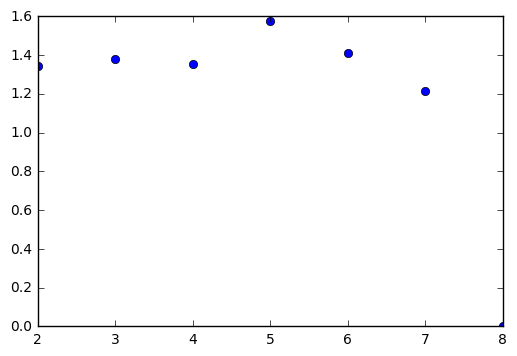

In [73]:
from numpy import *  
def hurst(p):  
    tau = []; lagvec = []  
    #  Step through the different lags  
    for lag in range(2,20):  
        #  produce price difference with lag  
        pp = subtract(p[lag:],p[:-lag])  
        #  Write the different lags into a vector  
        lagvec.append(lag)  
        #  Calculate the variance of the differnce vector  
        tau.append(sqrt(std(pp)))  
    #  linear fit to double-log graph (gives power)  
    m = polyfit(log10(lagvec),log10(tau),1)  
    # calculate hurst  
    hurst = m[0]*2  
    # plot lag vs variance  
    plt.plot(lagvec,tau,'o')
    return hurst  
if __name__=="__main__":  
    #  Different types of time series for testing  
    print hurst(price_adjustment_index['city']) 
    # trending, hurst ~ 1; mean reverting, hurst ~ 0; random walk, hurst ~ 0.5

In [74]:
 def normcdf(X):
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) + a4*pow(K,4) + a5*pow(K,5))
    if X<0:
        w = 1.0-w
    return w
 
 
def vratio(a, lag = 2, cor = 'hom'):
    t = (std((a[lag:]) - (a[1:-lag+1])))**2;
    b = (std((a[2:]) - (a[1:-1]) ))**2;
 
    n = float(len(a))
    mu  = sum(a[1:n]-a[:-1])/n;
    m=(n-lag+1)*(1-lag/n);
#   print mu, m, lag
    b=sum(square(a[1:n]-a[:n-1]-mu))/(n-1)
    t=sum(square(a[lag:n]-a[:n-lag]-lag*mu))/m
    vratio = t/(lag*b);
 
    la = float(lag)
     
 
    if cor == 'hom':
        varvrt=2*(2*la-1)*(la-1)/(3*la*n)
 
 
    elif cor == 'het':
          varvrt=0;
          sum2=sum(square(a[1:n]-a[:n-1]-mu)); 
          for j in range(lag-1):
             sum1a=square(a[j+1:n]-a[j:n-1]-mu); 
             sum1b=square(a[1:n-j]-a[0:n-j-1]-mu)
             sum1=dot(sum1a,sum1b); 
             delta=sum1/(sum2**2);
             varvrt=varvrt+((2*(la-j)/la)**2)*delta
 
    zscore = (vratio - 1) / sqrt(float(varvrt))
    pval = normcdf(zscore);
 
    return  vratio, zscore, pval
 
if __name__=="__main__":
 
    print vratio(price_adjustment_index['city'].values, cor = 'het', lag = 5)

(1.3044516775091617, 0.27908055517143032, 0.60990843647369886)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will r

only 468transactions in Chandler city
only 450transactions in Glendale city 0
only 415transactions in Surprise city 0
only 362transactions in Deer Valley
only 350transactions in Peoria city 0
only 322transactions in Maryvale
only 302transactions in North Scottsdale
only 296transactions in Avondale city
only 269transactions in North Mountain
only 266transactions in South Scottsdale
only 263transactions in Goodyear city 0
only 234transactions in Laveen
only 222transactions in Estrella
only 219transactions in South Mountain
only 202transactions in Desert View
only 193transactions in Southeast 0
only 189transactions in Alahambra
only 189transactions in Camelback East
only 187transactions in Buckeye town 0
only 151transactions in Ahwatukee Foothills 0
only 126transactions in Anthem CDP
only 119transactions in Paradise Valley
only 114transactions in Encanto
only 95transactions in El Mirage city
only 78transactions in Northeast 0
only 77transactions in Southwest
only 61transactions in Pinnacl

neighborhood,Period,Growth Rate,P Value,n
Gilbert town 0,2016,1.18,54.66,615


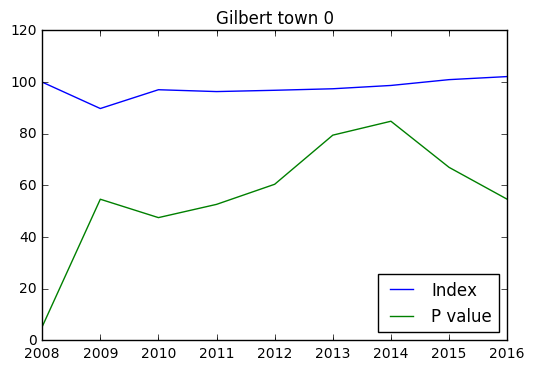

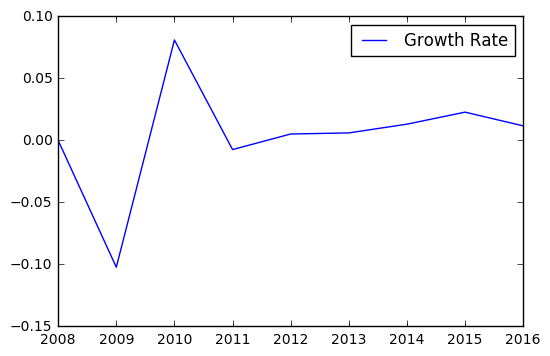

In [75]:
for hood in paired[boundary].unique():
    sorted_zips.append([hood, len(paired[paired[boundary] == hood])])
    
for hood, n in sorted(sorted_zips, key =lambda x: x[1], reverse=True):
    d = paired[paired[boundary] == hood]
    if len(d) < 500:
        print 'only ' + `len(d)` + 'transactions in ' + hood
        continue

    res = sm.ols(formula="np.log(price) ~ period + address", data=d).fit()

    #calculate index
    linked = res.params[res.params.index.str.contains('Period')]
    linked.name = "Index"
    linked[0] = 100
    
    growth = pd.Series(linked, copy=True)
    growth.name = "Growth Rate"
    growth[0] = 0
    for i in range(1,len(linked)):
        linked[i] = (np.exp(res.params[i]))*100
        growth[i] = linked[i]/linked[i-1] - 1

    # add P values of each prediction
    p = res.pvalues[res.params.index.str.contains('Period')] * 100
    p.name = "P value"
    index = pd.concat([linked, growth, p], axis=1)
    
    index.index = pd.to_datetime(index.index.str.split("'").str.get(1)).to_period(z)
    
    # update the price adjustment index to be used for later regressions
    price_adjustment_index[hood] = index['Index']  
    
    last = index.tail(1)
    table.append([hood
                  ,last.index[0]
                  ,round(last.iloc[0]['Growth Rate'] * 100,2)
                  ,round(last.iloc[0]['P value'], 2)
                  ,n])

    index[['Index','P value']].plot(title=hood)
    index[['Growth Rate']].plot()

table

In [76]:
def g(listing): 
#     print 'price: ' + `listing.price`
#     print 'year: ' + `listing.year`
#     print 'hood: ' + listing[boundary]
    try:
        index_value = price_adjustment_index[listing[boundary]][listing.year] / price_adjustment_index[listing[boundary]][2016]
    except KeyError:
        try:
            index_value = price_adjustment_index['city'][listing.year] / price_adjustment_index['city'][2016]
        except KeyError:
            index_value = 1
#     print index_value
    indexed_price = listing.price * index_value
#     print 'adj price: ' + `indexed_price`
    
    return indexed_price
    

In [77]:
indexed_price = data.apply(g, axis=1)
indexed_price.name = "indexed_price"
data = pd.concat([data,indexed_price],axis=1)

In [78]:
data[['indexed_price','price','year']].head()

,indexed_price,price,year
0,1218.626036,1250,2015
1,1300.000000,1300,2016
2,1300.000000,1300,2016
3,1944.927153,1995,2015
4,1218.626036,1250,2015


In [79]:
type(data.date.values[4])

datetime.date

In [80]:
from datetime import datetime
out_of_sample_data = data[data.date > datetime.strptime('2016-09-30','%Y-%m-%d').date()]
# out_of_sample_data.reset_index(inplace=True)
print "number of transactions in data: " + `len(data)` + "\texcluding latest " + `len(out_of_sample_data)` + " transactions"
in_sample_data = data[~data.date.isin(out_of_sample_data.date)]
print "number of transactions in data after exclusion: " + `len(in_sample_data)`


number of transactions in data: 50661	excluding latest 3649 transactions
number of transactions in data after exclusion: 47012


In [81]:
for z in set(out_of_sample_data.zipcode.unique()).difference(in_sample_data.zipcode.unique()):
    print("shoving missing zipcode into in_sample_data : ?", z)
    in_sample_data = in_sample_data.append(out_of_sample_data[out_of_sample_data.zipcode == z].head(1)) 

('shoving missing zipcode into in_sample_data : ?', '85712')


In [ ]:
# dist_to_park unit is 1 degree of latitude or 69 miles north south or 54 miles east west

result = sm.ols(formula="indexed_price ~ address +zipcode:sqft", data=in_sample_data).fit()
# bedrooms + bathrooms + elevation + age + dist_to_park + near_golf_course + has_pool + garage
result.summary()

In [83]:
print list(set(in_sample_data.zipcode.unique()).difference(out_of_sample_data.zipcode.unique()))

print list(set(out_of_sample_data.zipcode.unique()).difference(in_sample_data.zipcode.unique()))



['85390', '85034', '85142', '85281', '36601', '85361', '85004', '85139']
[]


In [84]:
for z in set(in_sample_data.zipcode.unique()).difference(out_of_sample_data.zipcode.unique()):
    print("shoving missing zipcode into out_of_sample_data : ?", z)
    out_of_sample_data = out_of_sample_data.append(in_sample_data[in_sample_data.zipcode == z].head(1)) 

('shoving missing zipcode into out_of_sample_data : ?', '85390')
('shoving missing zipcode into out_of_sample_data : ?', '85034')
('shoving missing zipcode into out_of_sample_data : ?', '85142')
('shoving missing zipcode into out_of_sample_data : ?', '85281')
('shoving missing zipcode into out_of_sample_data : ?', '36601')
('shoving missing zipcode into out_of_sample_data : ?', '85361')
('shoving missing zipcode into out_of_sample_data : ?', '85004')
('shoving missing zipcode into out_of_sample_data : ?', '85139')


In [85]:
print len(out_of_sample_data.zipcode.unique())
print len(in_sample_data.zipcode.unique())

125
125


In [86]:
import patsy
x = patsy.dmatrix("bedrooms + bathrooms + elevation + age + dist_to_park + near_golf_course + has_pool + garage + zipcode:sqft", data=out_of_sample_data) 
#  
p = result.predict(x, transform=False)
print 'length of prediction from .predict ' + `len(p)`
pprice_out = pd.Series(p)
pprice_out.name = "prediction"
print pprice_out.head()
print 'length of prediction price ' + `len(pprice_out)`
print 'length of out of sample ' + `len(out_of_sample_data)`
errors_out = out_of_sample_data.indexed_price.values - pprice_out
errors_out.name = 'error'
print errors_out.head()


length of prediction from .predict 3657
0    2372.242693
1    2372.242693
2    1915.580883
3    2249.265658
4    2249.265658
Name: prediction, dtype: float64
length of prediction price 3657
length of out of sample 3657
0    102.757307
1    102.757307
2   -215.580883
3   -254.265658
4   -254.265658
Name: error, dtype: float64


In [87]:
print 'length of OOS data: ' + `len(out_of_sample_data)`
print 'length of prediction: ' + `len(pprice_out)`
out_of_sample_data.reset_index(drop=True, inplace=True)
out_of_sample_result = pd.concat([out_of_sample_data,pprice_out,errors_out],axis=1)



length of OOS data: 3657
length of prediction: 3657


In [96]:
from sklearn import metrics

print( "r-squared: ", metrics.r2_score(out_of_sample_data.indexed_price.values,p))
print( "mse: ", metrics.mean_squared_error(out_of_sample_data.indexed_price.values,p))

('r-squared: ', 0.61474137020046249)
('mse: ', 131025.62574467785)


In [89]:
out_of_sample_result[['address','price','prediction','error','zipcode']].head()

,address,price,prediction,error,zipcode
0,"9423 E Camino Del Santo, Scottsdale, AZ 85260",2475,2372.242693,102.757307,85260
1,"9423 E Camino Del Santo, Scottsdale, AZ 85260",2475,2372.242693,102.757307,85260
2,"10032 E Gray Rd, Scottsdale, AZ 85260",1700,1915.580883,-215.580883,85260
3,"9273 E Pershing Ave, Scottsdale, AZ 85260",1995,2249.265658,-254.265658,85260
4,"9273 E Pershing Ave, Scottsdale, AZ 85260",1995,2249.265658,-254.265658,85260


In [90]:
percent_errors_out = (1.0 * out_of_sample_result.error.abs() / out_of_sample_result.price)
percent_errors_out.name = 'error'

print percent_errors_out.median()

hooderrors_out = out_of_sample_result[['zipcode']]
hooderrors_out = pd.concat([hooderrors_out,errors_out.abs()],axis=1)
hood_group_out = hooderrors_out.groupby('zipcode')

0.0981206828774


                error    
               median len
zipcode                  
36601    8.882580e-09   1
85003    1.971802e+02   6
85004    8.650464e+02   1
85006    1.561332e+02  19
85007    3.955130e+02   7


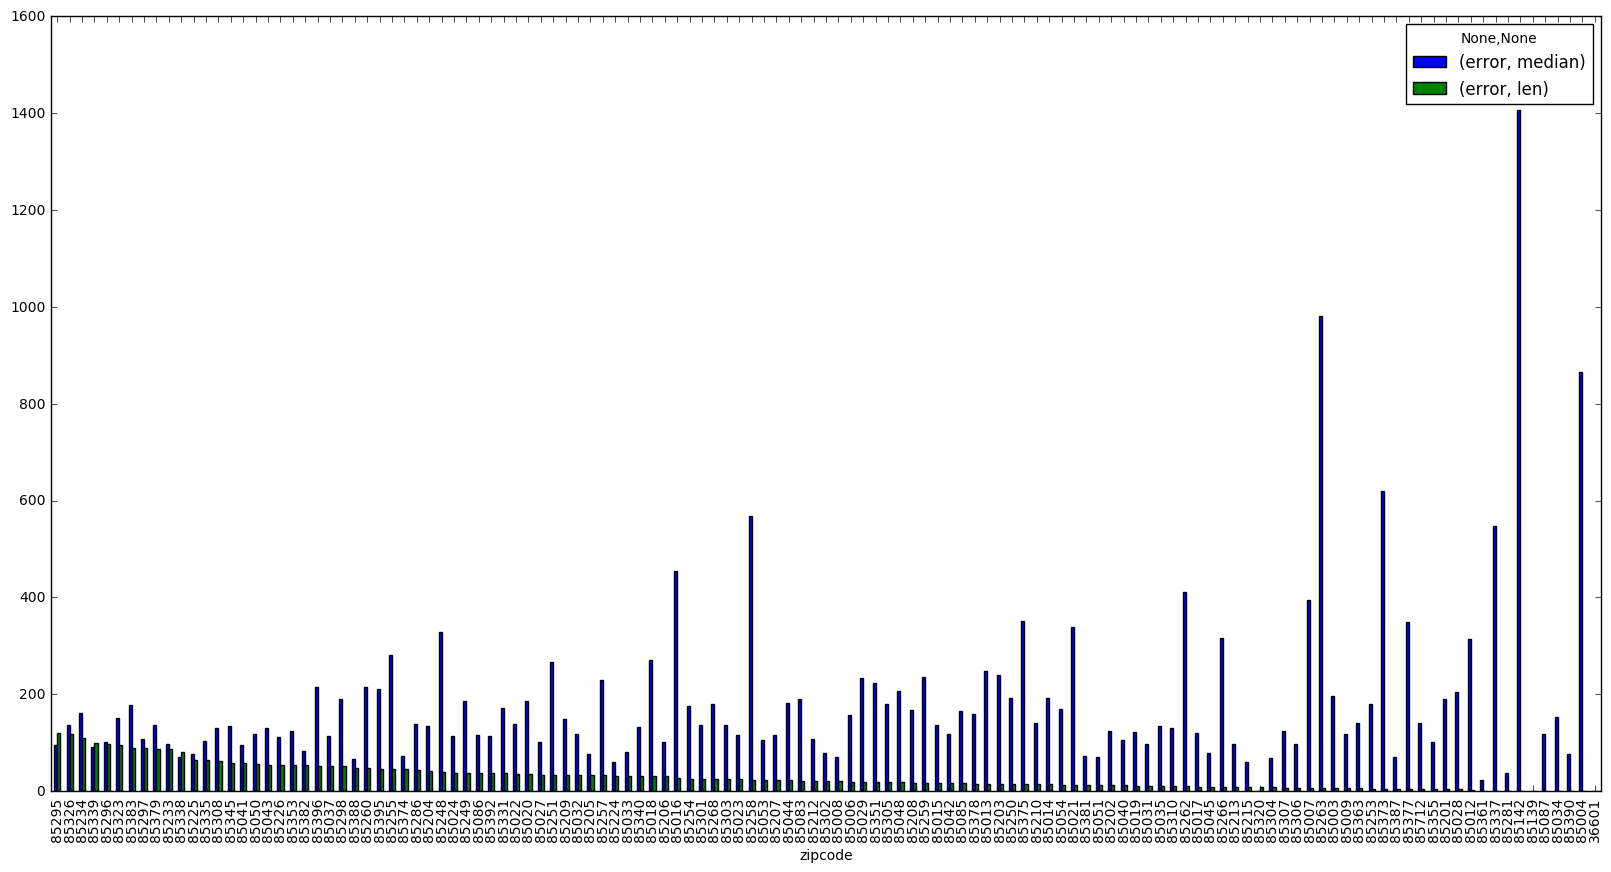

In [91]:
error_avg_out = hood_group_out.agg([np.median,len])
print error_avg_out.head()
error_avg_out.sort_values(by=('error','len'),ascending=False,inplace=True)
error_avg_out.plot(kind='bar',figsize=(20,10))

In [92]:
# out_of_sample_result[out_of_sample_result.zipcode == '85251'][['property_id','address','date','price','prediction','sqft']]

In [93]:
output = [['zipcode','sfh','multifamily']]
table = ListTable()
table.append(output[0])

for row in data.zipcode.unique():
    output_row = [row, '99', '99']
    for i in result.params.index:
        if 'zipcode' not in i: continue

        if 'zipcode[' + row + ']' in i:
            if 'home_type[mfh]' in i:
                output_row[2] = `result.params[i]`
                output.append(output_row)
                table.append(output_row)

            if 'home_type[sfh]' in i:
                output_row[1] = `result.params[i]`

table

zipcode,sfh,multifamily


In [94]:
path = 'rentalnerd_importer/lib/tasks/model_files/'

with open(path + 'model_zipcode_' + city + '.csv', 'wb') as csvfile:
    hoodwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for i in output:
        hoodwriter.writerow(i)

In [95]:
dtype = [('Effect', 'S100'), ('Coefficient', float)]

with open(path + 'model_features_' + city + '.csv', 'wb') as csvfile:
    modelwriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)

    header = ['Effect','Coefficient']
    table.append(header)
    modelwriter.writerow(header)
    modelwriter.writerow(['base_rent', result.params.Intercept])  # hardcode 0 as base rent
    modelwriter.writerow(['bedrooms', result.params.bedrooms])
    modelwriter.writerow(['bathrooms', result.params.bathrooms])
    modelwriter.writerow(['dist_to_park', result.params.dist_to_park])
    modelwriter.writerow(['elevation', result.params.elevation])
    modelwriter.writerow(['near_golf_course', result.params['near_golf_course[T.True]']])
    modelwriter.writerow(['level', result.params.level])
    modelwriter.writerow(['age', result.params.age])
    modelwriter.writerow(['garage', result.params.garage])
    modelwriter.writerow(['has_pool', result.params['has_pool[T.True]']])
    modelwriter.writerow(['mean square error of residuals', result.mse_resid])

result.cov_params().to_csv(path + 'model_covs_' + city + '.csv')

AttributeError: 'Series' object has no attribute 'level'

In [ ]:
output = [['district_id','coefficient']]
table = ListTable()
table.append(output[0])

for row in sorted(data.school_district_id.unique()):
    output_row = [row, '99']
    for i in result.params.index:
        if 'school_district_id' not in i: continue

        if 'school_district_id)[T.' + `row` + ']' in i:
            output_row[1] = `result.params[i]`
            output.append(output_row)
            table.append(output_row)

table

In [ ]:
with open(path + 'model_schools_' + city + '.csv', 'wb') as csvfile:
    schoolswriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    for i in output:
        schoolswriter.writerow(i)

In [ ]:
errors = result.resid
errors.name = 'error'
pprice = data.indexed_price - errors
pprice.name = "prediction"
data = pd.concat([data, errors], axis=1)
data = pd.concat([data, pprice], axis=1)

# visualize the relationship between the features and the response using scatterplots
errors.sort_values(inplace=True)
errors.plot(kind='bar').get_xaxis().set_ticks([])

# show errors by neighborhood to see if there are any neighborhoods with funky differences

hooderrors = data[['zipcode']]
hooderrors = pd.concat([hooderrors,errors.abs()],axis=1)
hood_group = hooderrors.groupby('zipcode')

In [ ]:
error_avg = hood_group.agg([np.median,len])
error_avg.sort_values(by=('error','len'),ascending=False,inplace=True)
error_avg.plot(kind='bar',figsize=(20,10))

In [ ]:
# show errors by year to see if there are any years with funky differences
yearerrors = data[['year']]
percent_errors = (1.0 * errors.abs() / data.price)
percent_errors.name = 'error'
yearerrors = pd.concat([yearerrors,percent_errors],axis=1)

year_group = yearerrors.groupby('year')
error_avg = year_group.median()
error_avg.plot(kind='bar')
print error_avg

# show errors by source to see if there are any sources have noisy data

srcerrors = data[['source']]

srcerrors = pd.concat([srcerrors,percent_errors],axis=1)

src_group = srcerrors.groupby('source')
error_avg = src_group.median()
error_avg.sort_values(by='error',ascending=False).plot(kind='bar')
